# Legal Document Summarizer
## Indian Supreme Court Judgments Analysis and Summarization

This notebook provides comprehensive tools for analyzing and summarizing Indian Supreme Court judgments using different text chunking strategies.

### Data Structure:
- **Original-Judgements/**: PDF files of court judgments
- **metadata/**: Case metadata (parties, citations, etc.)
- **Semantic/**: Semantically chunked text (meaning-based segments)
- **TokenWise/**: Token-based chunks (granular pieces)
- **Recursive/**: Recursively chunked text (hierarchical breakdown)

### Features:
1. Data loading and preprocessing
2. Comparative analysis of chunking strategies
3. Automated summarization
4. Key information extraction
5. Legal precedent identification
6. Case relationship mapping

In [3]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pathlib import Path
from collections import defaultdict, Counter
import json
from datetime import datetime
import glob

# Text processing
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
try:
    from textstat import flesch_reading_ease, flesch_kincaid_grade
except ImportError:
    print("textstat not available - install with: pip install textstat")

# NLP and summarization
try:
    from transformers import pipeline, AutoTokenizer, AutoModel
    from sentence_transformers import SentenceTransformer
except ImportError:
    print("transformers not available - install with: pip install transformers sentence-transformers")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"Current working directory: {os.getcwd()}")

transformers not available - install with: pip install transformers sentence-transformers
Libraries imported successfully!
Current working directory: d:\Indian-Supreme-Court-Judgements-Chunked


In [13]:
# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('tokenizers/punkt_tab')
    nltk.data.find('corpora/stopwords')
    print("NLTK data already available")
except LookupError:
    print("Downloading NLTK data...")
    nltk.download('punkt')
    nltk.download('punkt_tab')  # Add this line
    nltk.download('stopwords')
    nltk.download('averaged_perceptron_tagger')
    print("NLTK data downloaded successfully")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


NLTK data downloaded successfully


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [5]:
# Define data paths
BASE_DIR = Path('.')
METADATA_DIR = BASE_DIR / 'metadata'
SEMANTIC_DIR = BASE_DIR / 'Semantic'
TOKENWISE_DIR = BASE_DIR / 'TokenWise'
RECURSIVE_DIR = BASE_DIR / 'Recursive'
ORIGINAL_DIR = BASE_DIR / 'Original-Judgements'

# Verify directories exist
directories = {
    'Metadata': METADATA_DIR,
    'Semantic': SEMANTIC_DIR,
    'TokenWise': TOKENWISE_DIR,
    'Recursive': RECURSIVE_DIR,
    'Original': ORIGINAL_DIR
}

for name, path in directories.items():
    if path.exists():
        file_count = len(list(path.glob('*')))
        print(f"✓ {name}: {file_count} files found")
    else:
        print(f"✗ {name}: Directory not found")

✓ Metadata: 95 files found
✓ Semantic: 100 files found
✓ TokenWise: 100 files found
✓ Recursive: 100 files found
✓ Original: 100 files found


In [6]:
class LegalDocumentLoader:
    def __init__(self, base_dir='.'):
        self.base_dir = Path(base_dir)
        self.metadata_dir = self.base_dir / 'metadata'
        self.semantic_dir = self.base_dir / 'Semantic'
        self.tokenwise_dir = self.base_dir / 'TokenWise'
        self.recursive_dir = self.base_dir / 'Recursive'
        
    def load_metadata(self, file_number=None):
        """Load metadata for specific file or all files"""
        metadata_files = list(self.metadata_dir.glob('metadata*.txt'))
        
        if file_number:
            file_path = self.metadata_dir / f'metadata{file_number}.txt'
            if file_path.exists():
                with open(file_path, 'r', encoding='utf-8') as f:
                    return f.read().strip()
            return None
            
        metadata_dict = {}
        for file_path in metadata_files:
            file_num = re.search(r'metadata(\d+)\.txt', file_path.name)
            if file_num:
                num = file_num.group(1)
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        metadata_dict[num] = f.read().strip()
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")
        return metadata_dict
    
    def load_chunked_text(self, chunk_type, file_number=None):
        """Load chunked text from specified directory"""
        if chunk_type == 'semantic':
            directory = self.semantic_dir
            prefix = 'Semantic-Chunker-'
        elif chunk_type == 'tokenwise':
            directory = self.tokenwise_dir
            prefix = 'Token-Chunker-'
        elif chunk_type == 'recursive':
            directory = self.recursive_dir
            prefix = 'Recursive-Chunker-'
        else:
            raise ValueError("chunk_type must be 'semantic', 'tokenwise', or 'recursive'")
        
        if file_number:
            file_path = directory / f'{prefix}{file_number}.txt'
            if file_path.exists():
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        content = f.read()
                        # Split by '---' if it exists (for chunked content)
                        chunks = [chunk.strip() for chunk in content.split('---') if chunk.strip()]
                        return chunks if len(chunks) > 1 else [content]
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")
                    return None
            return None
        
        # Load all files
        all_files = {}
        files = list(directory.glob(f'{prefix}*.txt'))
        for file_path in files:
            file_num = re.search(rf'{prefix}(\d+)\.txt', file_path.name)
            if file_num:
                num = file_num.group(1)
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        content = f.read()
                        chunks = [chunk.strip() for chunk in content.split('---') if chunk.strip()]
                        all_files[num] = chunks if len(chunks) > 1 else [content]
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")
        return all_files
    
    def get_available_cases(self):
        """Get list of available case numbers"""
        metadata_files = list(self.metadata_dir.glob('metadata*.txt'))
        case_numbers = []
        for file_path in metadata_files:
            file_num = re.search(r'metadata(\d+)\.txt', file_path.name)
            if file_num:
                case_numbers.append(file_num.group(1))
        return sorted(case_numbers, key=int)

# Initialize loader
loader = LegalDocumentLoader()
available_cases = loader.get_available_cases()
print(f"Found {len(available_cases)} cases")
print(f"Case numbers range: {min(available_cases, key=int)} to {max(available_cases, key=int)}")

Found 95 cases
Case numbers range: 1 to 100


In [7]:
class TextAnalyzer:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.stemmer = PorterStemmer()
        
    def extract_basic_info(self, text):
        """Extract basic information from legal text"""
        info = {}
        
        # Extract case citation
        citation_pattern = r'(\d{4}\s+(?:INSC|SCC|SC)\s+\d+)'
        citations = re.findall(citation_pattern, text)
        info['citations'] = citations
        
        # Extract parties (APPELLANT vs RESPONDENT)
        parties_pattern = r'([A-Z\s\.\,]+)\s*…?\s*APPELLANT\s+VERSUS\s+([A-Z\s\.\,]+)\s*…?\s*RESPONDENT'
        parties = re.search(parties_pattern, text)
        if parties:
            info['appellant'] = parties.group(1).strip()
            info['respondent'] = parties.group(2).strip()
        
        # Extract judges
        judge_pattern = r'J U D G M E N T\s+([A-Z\s\.\,]+),?\s*J\.'
        judge = re.search(judge_pattern, text)
        if judge:
            info['judge'] = judge.group(1).strip()
        
        # Extract date
        date_pattern = r'(\d{1,2}\.\d{1,2}\.\d{4})'
        dates = re.findall(date_pattern, text)
        info['dates'] = dates
        
        return info
    
    def get_text_statistics(self, text):
        """Calculate text statistics"""
        stats = {}
        
        # Basic counts
        stats['char_count'] = len(text)
        stats['word_count'] = len(word_tokenize(text))
        stats['sentence_count'] = len(sent_tokenize(text))
        
        # Average lengths
        stats['avg_words_per_sentence'] = stats['word_count'] / max(stats['sentence_count'], 1)
        stats['avg_chars_per_word'] = stats['char_count'] / max(stats['word_count'], 1)
        
        # Readability (if textstat is available)
        try:
            stats['flesch_reading_ease'] = flesch_reading_ease(text)
            stats['flesch_kincaid_grade'] = flesch_kincaid_grade(text)
        except:
            stats['flesch_reading_ease'] = 'N/A'
            stats['flesch_kincaid_grade'] = 'N/A'
        
        return stats
    
    def extract_legal_entities(self, text):
        """Extract legal entities and concepts"""
        entities = {}
        
        # Legal acts and sections
        act_pattern = r'([A-Z][a-z\s]+Act,?\s*\d{4})'
        acts = re.findall(act_pattern, text)
        entities['acts'] = list(set(acts))
        
        # Section references
        section_pattern = r'Section\s+(\d+[A-Za-z]?(?:\(\d+\))?)'
        sections = re.findall(section_pattern, text)
        entities['sections'] = list(set(sections))
        
        # Case citations
        citation_pattern = r'([A-Z\s]+v\.?\s+[A-Z\s]+(?:\(\d{4}\)\s*\d+\s*[A-Z]+\s*\d+)?)'
        citations = re.findall(citation_pattern, text)
        entities['case_citations'] = [c.strip() for c in citations if len(c.strip()) > 10][:10]  # Limit to 10
        
        # Legal terms
        legal_terms = ['appeal', 'petition', 'writ', 'mandamus', 'certiorari', 'prohibition', 
                      'habeas corpus', 'jurisdiction', 'constitutional', 'fundamental rights',
                      'directive principles', 'due process', 'natural justice']
        
        found_terms = []
        text_lower = text.lower()
        for term in legal_terms:
            if term in text_lower:
                found_terms.append(term)
        entities['legal_terms'] = found_terms
        
        return entities

# Initialize analyzer
analyzer = TextAnalyzer()
print("Text analyzer initialized")

Text analyzer initialized


In [8]:
class LegalSummarizer:
    def __init__(self):
        self.tfidf = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1, 2))
        
    def extractive_summary(self, chunks, num_sentences=5):
        """Create extractive summary using TF-IDF scoring"""
        if not chunks:
            return "No content available for summarization"
        
        # Combine all chunks
        full_text = ' '.join(chunks)
        sentences = sent_tokenize(full_text)
        
        if len(sentences) <= num_sentences:
            return full_text
        
        # Calculate TF-IDF scores for sentences
        try:
            tfidf_matrix = self.tfidf.fit_transform(sentences)
            sentence_scores = np.array(tfidf_matrix.sum(axis=1)).flatten()
            
            # Get top sentences
            top_indices = sentence_scores.argsort()[-num_sentences:][::-1]
            top_indices = sorted(top_indices)
            
            summary_sentences = [sentences[i] for i in top_indices]
            return ' '.join(summary_sentences)
        except:
            # Fallback: return first few sentences
            return ' '.join(sentences[:num_sentences])
    
    def key_points_extraction(self, chunks):
        """Extract key legal points"""
        if not chunks:
            return []
        
        full_text = ' '.join(chunks)
        sentences = sent_tokenize(full_text)
        
        key_indicators = [
            'held that', 'decided that', 'ruled that', 'concluded that',
            'important to note', 'it is clear that', 'we find that',
            'court observed', 'bench held', 'judgment states',
            'ratio decidendi', 'obiter dicta'
        ]
        
        key_points = []
        for sentence in sentences:
            sentence_lower = sentence.lower()
            for indicator in key_indicators:
                if indicator in sentence_lower and len(sentence) > 50:
                    key_points.append(sentence.strip())
                    break
        
        return key_points[:10]  # Return top 10 key points
    
    def compare_chunking_strategies(self, case_number):
        """Compare different chunking strategies for a case"""
        comparison = {}
        
        strategies = ['semantic', 'tokenwise', 'recursive']
        
        for strategy in strategies:
            chunks = loader.load_chunked_text(strategy, case_number)
            if chunks:
                stats = {
                    'num_chunks': len(chunks),
                    'avg_chunk_length': np.mean([len(chunk) for chunk in chunks]),
                    'total_length': sum(len(chunk) for chunk in chunks),
                    'chunks': chunks
                }
                comparison[strategy] = stats
        
        return comparison

# Initialize summarizer
summarizer = LegalSummarizer()
print("Legal summarizer initialized")

Legal summarizer initialized


In [9]:
def visualize_chunking_comparison(case_number):
    """Visualize comparison of chunking strategies"""
    comparison = summarizer.compare_chunking_strategies(case_number)
    
    if not comparison:
        print(f"No data available for case {case_number}")
        return
    
    strategies = list(comparison.keys())
    num_chunks = [comparison[s]['num_chunks'] for s in strategies]
    avg_lengths = [comparison[s]['avg_chunk_length'] for s in strategies]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Number of chunks
    ax1.bar(strategies, num_chunks, color=['skyblue', 'lightcoral', 'lightgreen'])
    ax1.set_title(f'Number of Chunks - Case {case_number}')
    ax1.set_ylabel('Number of Chunks')
    
    # Average chunk length
    ax2.bar(strategies, avg_lengths, color=['skyblue', 'lightcoral', 'lightgreen'])
    ax2.set_title(f'Average Chunk Length - Case {case_number}')
    ax2.set_ylabel('Average Characters per Chunk')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nChunking Strategy Comparison for Case {case_number}:")
    for strategy in strategies:
        stats = comparison[strategy]
        print(f"{strategy.capitalize()}:")
        print(f"  - Chunks: {stats['num_chunks']}")
        print(f"  - Avg length: {stats['avg_chunk_length']:.0f} characters")
        print(f"  - Total length: {stats['total_length']} characters")
        print()

def plot_case_statistics():
    """Plot statistics across all cases"""
    all_metadata = loader.load_metadata()
    
    # Analyze text lengths
    case_lengths = {}
    for case_num in available_cases[:20]:  # Analyze first 20 cases
        semantic_chunks = loader.load_chunked_text('semantic', case_num)
        if semantic_chunks:
            total_length = sum(len(chunk) for chunk in semantic_chunks)
            case_lengths[case_num] = total_length
    
    if case_lengths:
        cases = list(case_lengths.keys())
        lengths = list(case_lengths.values())
        
        plt.figure(figsize=(12, 6))
        plt.bar(range(len(cases)), lengths)
        plt.xlabel('Case Number')
        plt.ylabel('Total Text Length (characters)')
        plt.title('Text Length Distribution Across Cases')
        plt.xticks(range(len(cases)), cases, rotation=45)
        plt.tight_layout()
        plt.show()

print("Visualization functions defined")

Visualization functions defined


In [10]:
def analyze_case(case_number, chunking_strategy='semantic', summary_length=5):
    """Comprehensive analysis of a single case"""
    print(f"{'='*60}")
    print(f"LEGAL DOCUMENT ANALYSIS - CASE {case_number}")
    print(f"{'='*60}")
    
    # Load metadata
    metadata = loader.load_metadata(case_number)
    if metadata:
        print(f"\n📋 CASE METADATA:")
        print(f"{metadata}")
        print()
    
    # Load chunked text
    chunks = loader.load_chunked_text(chunking_strategy, case_number)
    if not chunks:
        print(f"❌ No {chunking_strategy} chunks found for case {case_number}")
        return None
    
    # Basic text analysis
    full_text = ' '.join(chunks)
    basic_info = analyzer.extract_basic_info(full_text)
    text_stats = analyzer.get_text_statistics(full_text)
    legal_entities = analyzer.extract_legal_entities(full_text)
    
    print(f"📊 TEXT STATISTICS ({chunking_strategy.upper()} CHUNKING):")
    print(f"  • Number of chunks: {len(chunks)}") 
    print(f"  • Total characters: {text_stats['char_count']:,}")
    print(f"  • Total words: {text_stats['word_count']:,}")
    print(f"  • Total sentences: {text_stats['sentence_count']:,}")
    print(f"  • Avg words/sentence: {text_stats['avg_words_per_sentence']:.1f}")
    if text_stats['flesch_reading_ease'] != 'N/A':
        print(f"  • Reading ease: {text_stats['flesch_reading_ease']:.1f}")
        print(f"  • Grade level: {text_stats['flesch_kincaid_grade']:.1f}")
    print()
    
    # Case information
    if basic_info:
        print(f"⚖️  CASE INFORMATION:")
        if basic_info.get('appellant'):
            print(f"  • Appellant: {basic_info['appellant']}")
        if basic_info.get('respondent'):
            print(f"  • Respondent: {basic_info['respondent']}")
        if basic_info.get('judge'):
            print(f"  • Judge: {basic_info['judge']}")
        if basic_info.get('citations'):
            print(f"  • Citations: {', '.join(basic_info['citations'])}")
        print()
    
    # Legal entities
    if legal_entities:
        print(f"📚 LEGAL ENTITIES:")
        if legal_entities.get('acts'):
            print(f"  • Acts mentioned: {', '.join(legal_entities['acts'][:5])}")
        if legal_entities.get('sections'):
            print(f"  • Sections: {', '.join(legal_entities['sections'][:10])}")
        if legal_entities.get('legal_terms'):
            print(f"  • Key legal terms: {', '.join(legal_entities['legal_terms'][:10])}")
        print()
    
    # Generate summary
    summary = summarizer.extractive_summary(chunks, summary_length)
    print(f"📝 EXTRACTIVE SUMMARY ({summary_length} sentences):")
    print(f"{summary}")
    print()
    
    # Key points
    key_points = summarizer.key_points_extraction(chunks)
    if key_points:
        print(f"🔍 KEY LEGAL POINTS:")
        for i, point in enumerate(key_points[:5], 1):
            print(f"  {i}. {point}")
        print()
    
    # Chunking comparison
    print(f"📈 CHUNKING STRATEGY COMPARISON:")
    visualize_chunking_comparison(case_number)
    
    return {
        'metadata': metadata,
        'chunks': chunks,
        'basic_info': basic_info,
        'text_stats': text_stats,
        'legal_entities': legal_entities,
        'summary': summary,
        'key_points': key_points
    }

print("Main analysis workflow defined")

Main analysis workflow defined


In [11]:
def batch_analysis(case_numbers, chunking_strategy='semantic'):
    """Analyze multiple cases and create comparison report"""
    results = {}
    
    print(f"🔄 Starting batch analysis of {len(case_numbers)} cases...")
    
    for case_num in case_numbers:
        print(f"\nProcessing case {case_num}...")
        result = analyze_case(case_num, chunking_strategy, summary_length=3)
        if result:
            results[case_num] = result
        print("-" * 40)
    
    # Create summary report
    if results:
        print(f"\n{'='*60}")
        print(f"BATCH ANALYSIS SUMMARY REPORT")
        print(f"{'='*60}")
        
        # Statistics summary
        total_words = sum(r['text_stats']['word_count'] for r in results.values())
        avg_words = total_words / len(results)
        
        print(f"📊 AGGREGATE STATISTICS:")
        print(f"  • Cases analyzed: {len(results)}")
        print(f"  • Total words: {total_words:,}")
        print(f"  • Average words per case: {avg_words:,.0f}")
        print()
        
        # Most common legal terms
        all_terms = []
        for result in results.values():
            if result['legal_entities'].get('legal_terms'):
                all_terms.extend(result['legal_entities']['legal_terms'])
        
        if all_terms:
            term_counts = Counter(all_terms)
            print(f"🏛️  MOST COMMON LEGAL TERMS:")
            for term, count in term_counts.most_common(10):
                print(f"  • {term}: {count} cases")
            print()
    
    return results

# Function to save analysis results
def save_analysis_results(results, filename=None):
    """Save analysis results to JSON file"""
    if not filename:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"legal_analysis_results_{timestamp}.json"
    
    # Convert results to JSON-serializable format
    json_results = {}
    for case_num, result in results.items():
        json_results[case_num] = {
            'metadata': result['metadata'],
            'text_stats': result['text_stats'],
            'basic_info': result['basic_info'],
            'legal_entities': result['legal_entities'],
            'summary': result['summary'],
            'key_points': result['key_points']
        }
    
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(json_results, f, indent=2, ensure_ascii=False)
    
    print(f"✅ Results saved to {filename}")

print("Batch analysis and export functions defined")

Batch analysis and export functions defined


🚀 Starting Legal Document Analysis
Available cases: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

🔍 Analyzing case 1...
LEGAL DOCUMENT ANALYSIS - CASE 1

📋 CASE METADATA:
2024 INSC 640 REPORTABLE IN THE SUPREME COURT OF INDIA CIVIL APPELLATE JURISDICTION CIVIL APPEAL NOS. 9975-9976 OF 2024 [@ SPECIAL LEAVE PETITION (CIVIL) NOS.5034-5035 OF 2019 ] A. B. GOVARDHAN … APPELLANT VERSUS P. RAGOTHAMAN … RESPONDENT



📊 TEXT STATISTICS (SEMANTIC CHUNKING):
  • Number of chunks: 17
  • Total characters: 43,261
  • Total words: 8,216
  • Total sentences: 285
  • Avg words/sentence: 28.8
  • Reading ease: 51.1
  • Grade level: 11.2

⚖️  CASE INFORMATION:
  • Appellant: A. B. GOVARDHAN
  • Respondent: P. RAGOTHAMAN
  • Judge: AHSANUDDIN AMANULLAH,
  • Citations: 2024 INSC 640, 1965 SC 430, 1950 SCC 195, 1950 SC 272, 1965 SC 1591

📚 LEGAL ENTITIES:
  • Acts mentioned: Instruments Act, 1881, People Act, 1951, Registration Act, 1908, Property Act, 1882
  • Sections: 59, 138, 17, 116A, 58, 114, 17(1), 3
  • Key legal terms: appeal, petition, writ, jurisdiction

📝 EXTRACTIVE SUMMARY (5 sentences):
Order dated 12.07.2018 (hereinafter referred to as the “Second Impugned Order”) passed by the same Division Bench, whereby Civil Miscellaneous Petition3 No.10107 of 2017 in OSA No.189 of 2011 filed by the appellant seeking to “set aside” the First Impugned Order and restore the main appeal for fresh hearing, was di

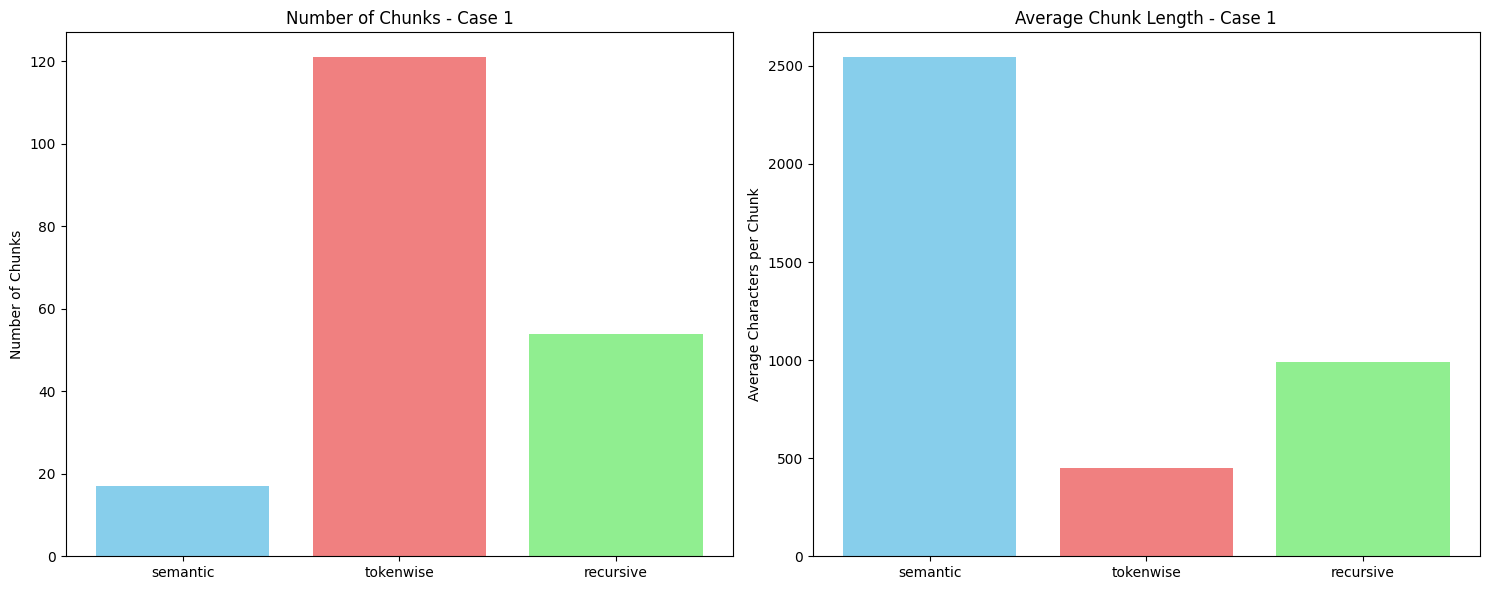


Chunking Strategy Comparison for Case 1:
Semantic:
  - Chunks: 17
  - Avg length: 2544 characters
  - Total length: 43245 characters

Tokenwise:
  - Chunks: 121
  - Avg length: 448 characters
  - Total length: 54149 characters

Recursive:
  - Chunks: 54
  - Avg length: 993 characters
  - Total length: 53616 characters


📊 Detailed chunking comparison:


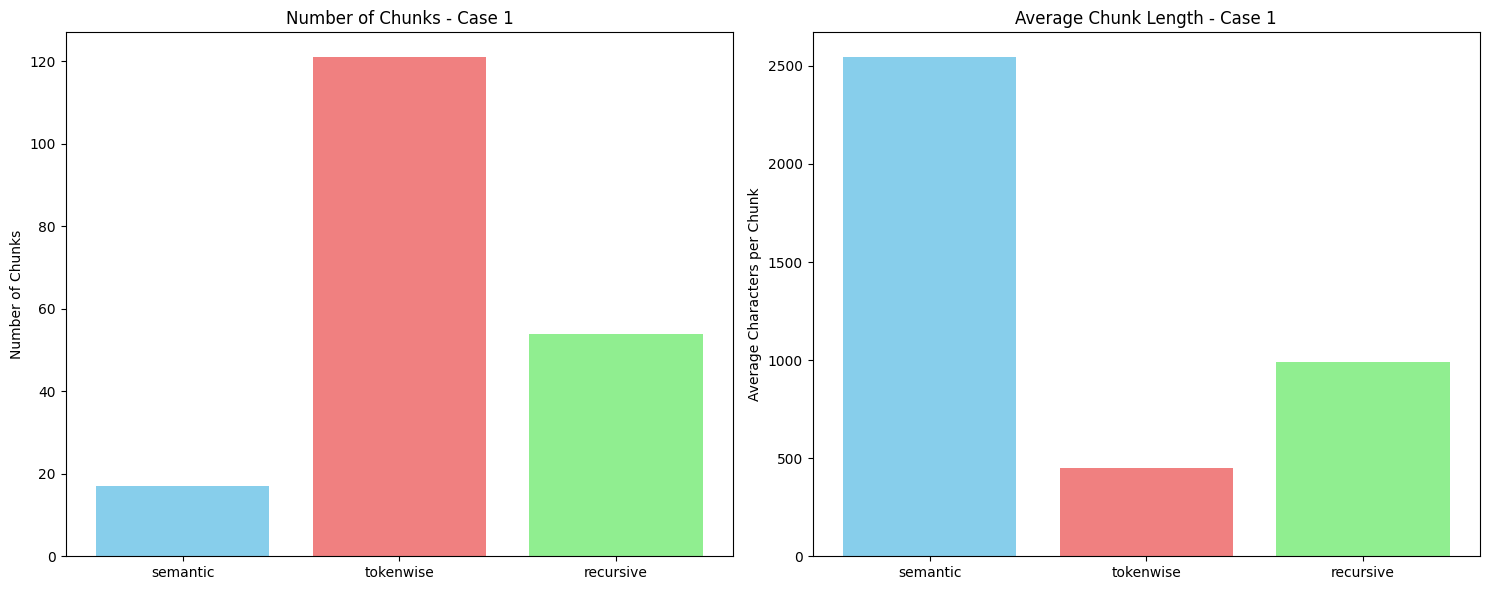


Chunking Strategy Comparison for Case 1:
Semantic:
  - Chunks: 17
  - Avg length: 2544 characters
  - Total length: 43245 characters

Tokenwise:
  - Chunks: 121
  - Avg length: 448 characters
  - Total length: 54149 characters

Recursive:
  - Chunks: 54
  - Avg length: 993 characters
  - Total length: 53616 characters



In [14]:
# Example: Analyze a specific case
print("🚀 Starting Legal Document Analysis")
print("Available cases:", available_cases[:10])  # Show first 10 available cases

# Choose a case to analyze (you can change this number)
if available_cases:
    case_to_analyze = available_cases[0]  # First available case
    print(f"\n🔍 Analyzing case {case_to_analyze}...")
    
    # Single case analysis
    result = analyze_case(case_to_analyze, chunking_strategy='semantic', summary_length=5)
    
    # Compare chunking strategies visualization
    print(f"\n📊 Detailed chunking comparison:")
    visualize_chunking_comparison(case_to_analyze)
    
else:
    print("❌ No cases available for analysis")


🔄 Running batch analysis on cases: ['1', '2', '3']
🔄 Starting batch analysis of 3 cases...

Processing case 1...
LEGAL DOCUMENT ANALYSIS - CASE 1

📋 CASE METADATA:
2024 INSC 640 REPORTABLE IN THE SUPREME COURT OF INDIA CIVIL APPELLATE JURISDICTION CIVIL APPEAL NOS. 9975-9976 OF 2024 [@ SPECIAL LEAVE PETITION (CIVIL) NOS.5034-5035 OF 2019 ] A. B. GOVARDHAN … APPELLANT VERSUS P. RAGOTHAMAN … RESPONDENT

📊 TEXT STATISTICS (SEMANTIC CHUNKING):
  • Number of chunks: 17
  • Total characters: 43,261
  • Total words: 8,216
  • Total sentences: 285
  • Avg words/sentence: 28.8
  • Reading ease: 51.1
  • Grade level: 11.2

⚖️  CASE INFORMATION:
  • Appellant: A. B. GOVARDHAN
  • Respondent: P. RAGOTHAMAN
  • Judge: AHSANUDDIN AMANULLAH,
  • Citations: 2024 INSC 640, 1965 SC 430, 1950 SCC 195, 1950 SC 272, 1965 SC 1591

📚 LEGAL ENTITIES:
  • Acts mentioned: Instruments Act, 1881, People Act, 1951, Registration Act, 1908, Property Act, 1882
  • Sections: 59, 138, 17, 116A, 58, 114, 17(1), 3
  • K

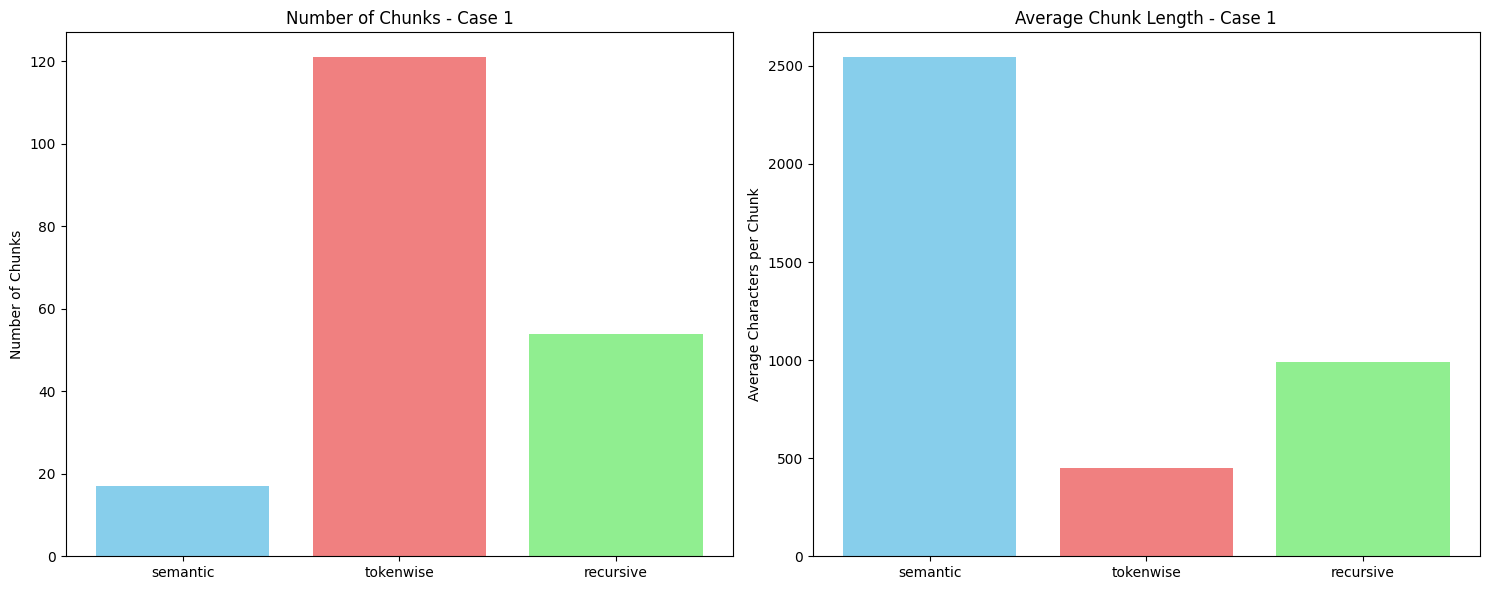


Chunking Strategy Comparison for Case 1:
Semantic:
  - Chunks: 17
  - Avg length: 2544 characters
  - Total length: 43245 characters

Tokenwise:
  - Chunks: 121
  - Avg length: 448 characters
  - Total length: 54149 characters

Recursive:
  - Chunks: 54
  - Avg length: 993 characters
  - Total length: 53616 characters

----------------------------------------

Processing case 2...
LEGAL DOCUMENT ANALYSIS - CASE 2

📋 CASE METADATA:
2024 INSC 780 REPORTABLE IN THE SUPREME COURT OF INDIA CIVIL APPELLATE JURISDICTION CIVIL APPEAL NOS. OF 2024 (Arising out of S.L.P. (C) Nos. 8159-8160 OF 2023) IDBI BANK LTD. …APPELLANT(S) VERSUS RAMSWAROOP DALIYA AND ORS. …RESPONDENT(S)

📊 TEXT STATISTICS (SEMANTIC CHUNKING):
  • Number of chunks: 8
  • Total characters: 15,863
  • Total words: 2,955
  • Total sentences: 113
  • Avg words/sentence: 26.2
  • Reading ease: 47.8
  • Grade level: 12.4

⚖️  CASE INFORMATION:
  • Judge: PANKAJ MITHAL,
  • Citations: 2024 INSC 780

📚 LEGAL ENTITIES:
  • Key legal

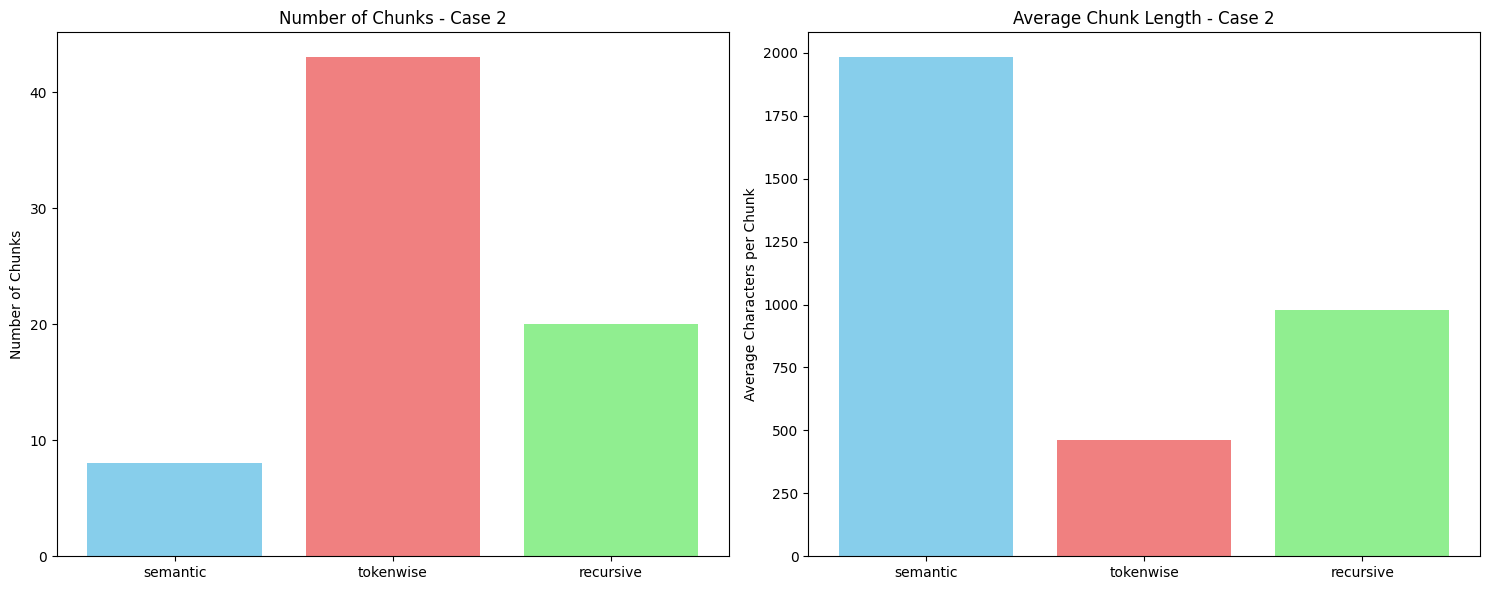


Chunking Strategy Comparison for Case 2:
Semantic:
  - Chunks: 8
  - Avg length: 1982 characters
  - Total length: 15856 characters

Tokenwise:
  - Chunks: 43
  - Avg length: 463 characters
  - Total length: 19919 characters

Recursive:
  - Chunks: 20
  - Avg length: 978 characters
  - Total length: 19563 characters

----------------------------------------

Processing case 3...
LEGAL DOCUMENT ANALYSIS - CASE 3

📋 CASE METADATA:
NON-REPORTABLE 2024 INSC 814 IN THE SUPREME COURT OF INDIA CIVIL APPELLATE JURISDICTION CIVIL APPEAL NO(s). OF 2024 (Arising out of Special Leave Petition Nos. 9202-9204 of 2016) JOGINDER SINGH (DEAD) THR. LRs … APPELLANT(S) Versus DR. VIRINDERJIT SINGH GILL (DEAD) THR. LRS. & ORS. ... RESPONDENT(S)

📊 TEXT STATISTICS (SEMANTIC CHUNKING):
  • Number of chunks: 24
  • Total characters: 52,241
  • Total words: 10,255
  • Total sentences: 388
  • Avg words/sentence: 26.4
  • Reading ease: 56.2
  • Grade level: 10.4

⚖️  CASE INFORMATION:
  • Judge: SANJAY KAROL
 

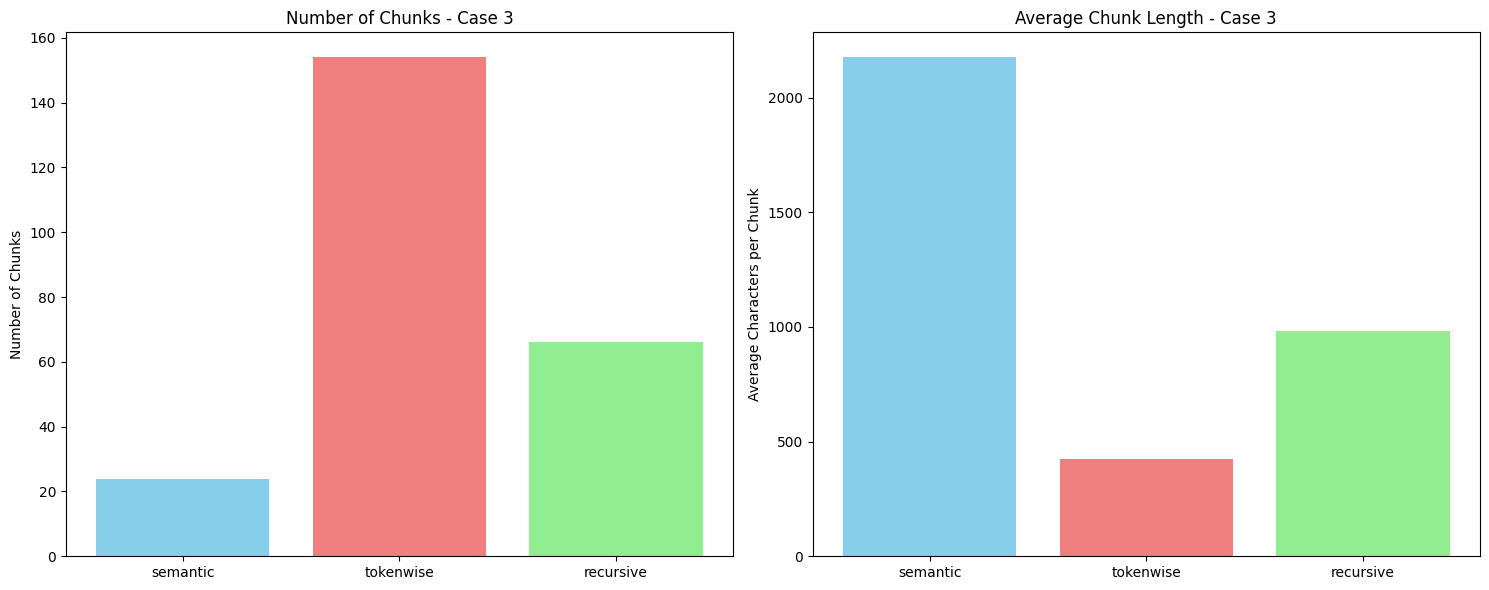


Chunking Strategy Comparison for Case 3:
Semantic:
  - Chunks: 24
  - Avg length: 2176 characters
  - Total length: 52218 characters

Tokenwise:
  - Chunks: 154
  - Avg length: 425 characters
  - Total length: 65385 characters

Recursive:
  - Chunks: 66
  - Avg length: 984 characters
  - Total length: 64970 characters

----------------------------------------

BATCH ANALYSIS SUMMARY REPORT
📊 AGGREGATE STATISTICS:
  • Cases analyzed: 3
  • Total words: 21,426
  • Average words per case: 7,142

🏛️  MOST COMMON LEGAL TERMS:
  • appeal: 3 cases
  • petition: 3 cases
  • writ: 3 cases
  • jurisdiction: 3 cases
  • natural justice: 1 cases
  • prohibition: 1 cases

✅ Results saved to legal_analysis_results_20250710_092459.json

📈 Plotting case statistics...


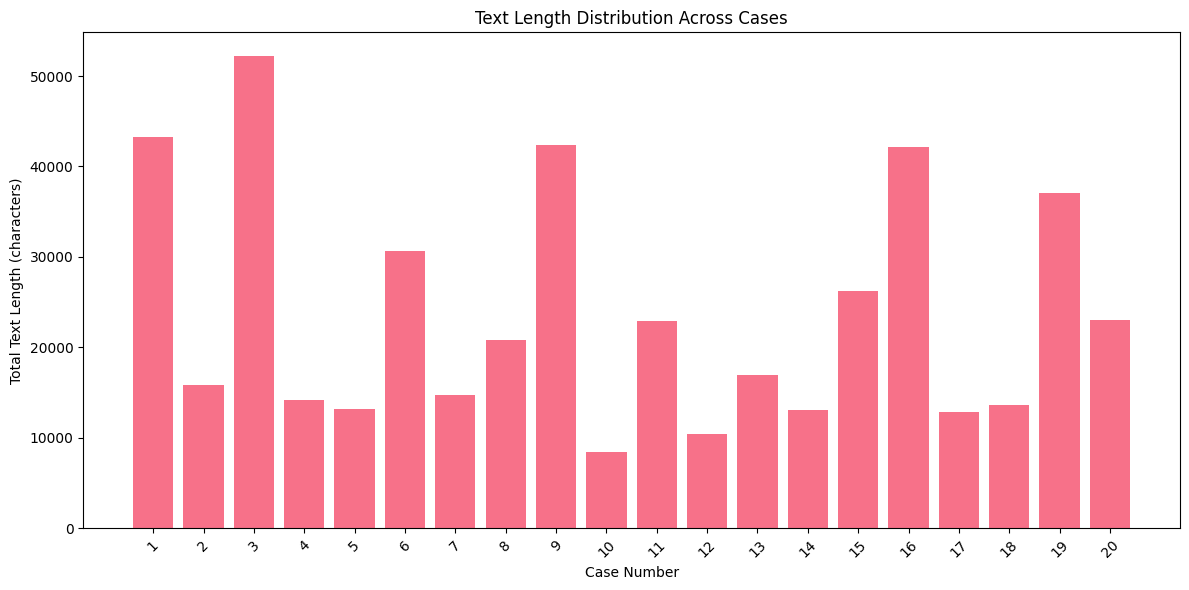

In [15]:
# Batch analysis of multiple cases
if len(available_cases) >= 3:
    # Analyze first 3 cases
    cases_to_analyze = available_cases[:3]
    print(f"\n🔄 Running batch analysis on cases: {cases_to_analyze}")
    
    batch_results = batch_analysis(cases_to_analyze, chunking_strategy='semantic')
    
    # Save results
    if batch_results:
        save_analysis_results(batch_results)
        
        # Plot overall statistics
        print(f"\n📈 Plotting case statistics...")
        plot_case_statistics()
else:
    print("❌ Need at least 3 cases for batch analysis")

In [16]:
def find_similar_cases(target_case, all_cases=None, top_n=5):
    """Find cases similar to target case using TF-IDF similarity"""
    if not all_cases:
        all_cases = available_cases[:10]  # Use first 10 cases
    
    print(f"🔍 Finding cases similar to case {target_case}...")
    
    # Load all case texts
    case_texts = {}
    for case_num in all_cases:
        chunks = loader.load_chunked_text('semantic', case_num)
        if chunks:
            case_texts[case_num] = ' '.join(chunks)
    
    if target_case not in case_texts:
        print(f"❌ Target case {target_case} not found")
        return []
    
    # Calculate TF-IDF similarity
    texts = list(case_texts.values())
    case_numbers = list(case_texts.keys())
    
    tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
    tfidf_matrix = tfidf.fit_transform(texts)
    
    # Find target case index
    target_idx = case_numbers.index(target_case)
    
    # Calculate similarities
    similarities = cosine_similarity(tfidf_matrix[target_idx:target_idx+1], tfidf_matrix).flatten()
    
    # Get top similar cases (excluding the target case itself)
    similar_indices = similarities.argsort()[::-1][1:top_n+1]
    
    similar_cases = []
    for idx in similar_indices:
        similar_cases.append({
            'case_number': case_numbers[idx],
            'similarity_score': similarities[idx]
        })
    
    print(f"📋 Top {top_n} similar cases to case {target_case}:")
    for i, case in enumerate(similar_cases, 1):
        print(f"  {i}. Case {case['case_number']}: {case['similarity_score']:.3f} similarity")
    
    return similar_cases

def generate_comprehensive_report(case_number):
    """Generate a comprehensive analysis report for a case"""
    print(f"📄 Generating comprehensive report for case {case_number}...")
    
    report = f"""
# COMPREHENSIVE LEGAL ANALYSIS REPORT
## Case Number: {case_number}
Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

"""
    
    # Analyze with each chunking strategy
    strategies = ['semantic', 'tokenwise', 'recursive']
    strategy_results = {}
    
    for strategy in strategies:
        chunks = loader.load_chunked_text(strategy, case_number)
        if chunks:
            full_text = ' '.join(chunks)
            stats = analyzer.get_text_statistics(full_text)
            summary = summarizer.extractive_summary(chunks, 3)
            strategy_results[strategy] = {
                'stats': stats,
                'summary': summary,
                'chunks': len(chunks)
            }
    
    # Add chunking comparison to report
    report += "## Chunking Strategy Analysis\n\n"
    for strategy, results in strategy_results.items():
        report += f"### {strategy.capitalize()} Chunking\n"
        report += f"- Number of chunks: {results['chunks']}\n"
        report += f"- Total words: {results['stats']['word_count']:,}\n"
        report += f"- Summary: {results['summary'][:200]}...\n\n"
    
    # Save report
    filename = f"comprehensive_report_case_{case_number}.md"
    with open(filename, 'w', encoding='utf-8') as f:
        f.write(report)
    
    print(f"✅ Report saved as {filename}")
    return report

print("Advanced analysis functions defined")

Advanced analysis functions defined


🎯 INTERACTIVE LEGAL DOCUMENT ANALYSIS
Available cases: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20

📍 Selected case: 1

Choose analysis type:
1. Quick summary
2. Detailed analysis
3. Chunking comparison
4. Find similar cases
5. Comprehensive report
LEGAL DOCUMENT ANALYSIS - CASE 1

📋 CASE METADATA:
2024 INSC 640 REPORTABLE IN THE SUPREME COURT OF INDIA CIVIL APPELLATE JURISDICTION CIVIL APPEAL NOS. 9975-9976 OF 2024 [@ SPECIAL LEAVE PETITION (CIVIL) NOS.5034-5035 OF 2019 ] A. B. GOVARDHAN … APPELLANT VERSUS P. RAGOTHAMAN … RESPONDENT

📊 TEXT STATISTICS (SEMANTIC CHUNKING):
  • Number of chunks: 17
  • Total characters: 43,261
  • Total words: 8,216
  • Total sentences: 285
  • Avg words/sentence: 28.8
  • Reading ease: 51.1
  • Grade level: 11.2

⚖️  CASE INFORMATION:
  • Appellant: A. B. GOVARDHAN
  • Respondent: P. RAGOTHAMAN
  • Judge: AHSANUDDIN AMANULLAH,
  • Citations: 2024 INSC 640, 1965 SC 430, 1950 SCC 195, 1950 SC 272, 1965 SC 1591

📚 LEGAL ENTITIES:

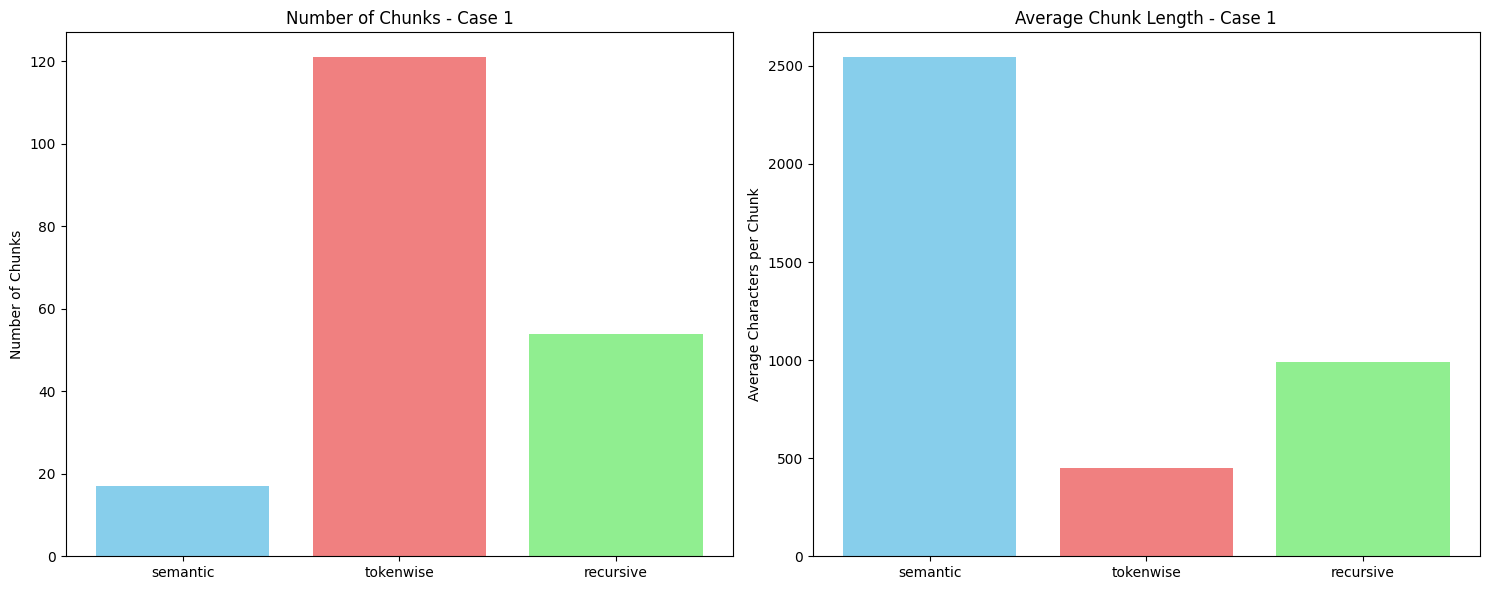


Chunking Strategy Comparison for Case 1:
Semantic:
  - Chunks: 17
  - Avg length: 2544 characters
  - Total length: 43245 characters

Tokenwise:
  - Chunks: 121
  - Avg length: 448 characters
  - Total length: 54149 characters

Recursive:
  - Chunks: 54
  - Avg length: 993 characters
  - Total length: 53616 characters



In [17]:
# Interactive case selection and analysis
def interactive_analysis():
    """Run interactive analysis with user choices"""
    print("🎯 INTERACTIVE LEGAL DOCUMENT ANALYSIS")
    print("=" * 50)
    
    print(f"Available cases: {', '.join(available_cases[:20])}")
    
    # In a real Jupyter environment, you could use input()
    # For now, we'll use the first available case
    if available_cases:
        selected_case = available_cases[0]
        print(f"\n📍 Selected case: {selected_case}")
        
        print("\nChoose analysis type:")
        print("1. Quick summary")
        print("2. Detailed analysis") 
        print("3. Chunking comparison")
        print("4. Find similar cases")
        print("5. Comprehensive report")
        
        # For demonstration, let's run a detailed analysis
        analysis_type = "2"  # You can change this
        
        if analysis_type == "1":
            chunks = loader.load_chunked_text('semantic', selected_case)
            if chunks:
                summary = summarizer.extractive_summary(chunks, 3)
                print(f"\n📝 Quick Summary:\n{summary}")
                
        elif analysis_type == "2":
            analyze_case(selected_case, 'semantic', 5)
            
        elif analysis_type == "3":
            visualize_chunking_comparison(selected_case)
            
        elif analysis_type == "4":
            find_similar_cases(selected_case, available_cases[:10])
            
        elif analysis_type == "5":
            generate_comprehensive_report(selected_case)
    
    else:
        print("❌ No cases available")

# Run interactive analysis
interactive_analysis()

In [18]:
print("🎉 LEGAL DOCUMENT SUMMARIZER SETUP COMPLETE!")
print("=" * 60)

print("\n✅ What you can do now:")
print("1. Analyze individual cases with: analyze_case(case_number)")
print("2. Compare chunking strategies with: visualize_chunking_comparison(case_number)")
print("3. Run batch analysis with: batch_analysis(case_list)")
print("4. Find similar cases with: find_similar_cases(target_case)")
print("5. Generate reports with: generate_comprehensive_report(case_number)")

print(f"\n📊 Available for analysis: {len(available_cases)} cases")
print(f"📁 Data directories verified and loaded")
print(f"🔧 All analysis tools ready")

print("\n🚀 Example commands to try:")
print("# Analyze case 1 with semantic chunking")
print("analyze_case('1', 'semantic', 5)")
print()
print("# Compare chunking strategies for case 1") 
print("visualize_chunking_comparison('1')")
print()
print("# Find cases similar to case 1")
print("find_similar_cases('1', available_cases[:10])")
print()
print("# Generate comprehensive report")
print("generate_comprehensive_report('1')")

print("\n" + "=" * 60)
print("Happy analyzing! 📚⚖️")

🎉 LEGAL DOCUMENT SUMMARIZER SETUP COMPLETE!

✅ What you can do now:
1. Analyze individual cases with: analyze_case(case_number)
2. Compare chunking strategies with: visualize_chunking_comparison(case_number)
3. Run batch analysis with: batch_analysis(case_list)
4. Find similar cases with: find_similar_cases(target_case)
5. Generate reports with: generate_comprehensive_report(case_number)

📊 Available for analysis: 95 cases
📁 Data directories verified and loaded
🔧 All analysis tools ready

🚀 Example commands to try:
# Analyze case 1 with semantic chunking
analyze_case('1', 'semantic', 5)

# Compare chunking strategies for case 1
visualize_chunking_comparison('1')

# Find cases similar to case 1
find_similar_cases('1', available_cases[:10])

# Generate comprehensive report
generate_comprehensive_report('1')

Happy analyzing! 📚⚖️


In [19]:
# Interactive Case Summarizer
def interactive_case_summarizer():
    """Interactive function to get summary for any case number"""
    print("🎯 INTERACTIVE LEGAL CASE SUMMARIZER")
    print("=" * 50)
    
    print(f"Available cases: {', '.join(available_cases)}")
    
    # Input case number (in Jupyter you can use input(), for demo we'll use a variable)
    case_number = input("Enter case number to analyze: ").strip()
    
    if case_number not in available_cases:
        print(f"❌ Case {case_number} not found!")
        print(f"Available cases: {', '.join(available_cases)}")
        return None
    
    # Input summary preferences
    print("\nSummarization Options:")
    print("1. Semantic chunking")
    print("2. Token-wise chunking") 
    print("3. Recursive chunking")
    
    strategy_choice = input("Choose chunking strategy (1-3): ").strip()
    strategy_map = {'1': 'semantic', '2': 'tokenwise', '3': 'recursive'}
    chunking_strategy = strategy_map.get(strategy_choice, 'semantic')
    
    summary_length = input("Number of sentences in summary (default 5): ").strip()
    summary_length = int(summary_length) if summary_length.isdigit() else 5
    
    print(f"\n🔍 Analyzing case {case_number} with {chunking_strategy} chunking...")
    print("=" * 60)
    
    # Load and analyze the case
    chunks = loader.load_chunked_text(chunking_strategy, case_number)
    if not chunks:
        print(f"❌ No {chunking_strategy} chunks found for case {case_number}")
        return None
    
    # Get basic info
    full_text = ' '.join(chunks)
    basic_info = analyzer.extract_basic_info(full_text)
    text_stats = analyzer.get_text_statistics(full_text)
    
    # Generate summary
    summary = summarizer.extractive_summary(chunks, summary_length)
    key_points = summarizer.key_points_extraction(chunks)
    
    # Display results
    print(f"📊 CASE STATISTICS:")
    print(f"  • Case Number: {case_number}")
    print(f"  • Chunking Strategy: {chunking_strategy}")
    print(f"  • Number of chunks: {len(chunks)}")
    print(f"  • Total characters: {text_stats['char_count']:,}")
    print(f"  • Total words: {text_stats['word_count']:,}")
    print(f"  • Total sentences: {text_stats['sentence_count']:,}")
    
    if basic_info.get('appellant') and basic_info.get('respondent'):
        print(f"\n⚖️ CASE DETAILS:")
        print(f"  • Appellant: {basic_info['appellant']}")
        print(f"  • Respondent: {basic_info['respondent']}")
        if basic_info.get('judge'):
            print(f"  • Judge: {basic_info['judge']}")
    
    print(f"\n📝 SUMMARY ({summary_length} sentences):")
    print("=" * 50)
    print(summary)
    
    if key_points:
        print(f"\n🔍 KEY LEGAL POINTS:")
        for i, point in enumerate(key_points[:3], 1):
            print(f"{i}. {point}")
    
    return {
        'case_number': case_number,
        'chunking_strategy': chunking_strategy,
        'summary': summary,
        'full_text': full_text,
        'chunks': chunks,
        'text_stats': text_stats,
        'key_points': key_points
    }

# For demo purposes, let's create a simplified version that doesn't require input()
def quick_case_summary(case_number, chunking_strategy='semantic', summary_length=5):
    """Quick case summary function"""
    if case_number not in available_cases:
        print(f"❌ Case {case_number} not found!")
        return None
    
    print(f"🔍 QUICK SUMMARY - CASE {case_number}")
    print("=" * 40)
    
    # Load and analyze
    chunks = loader.load_chunked_text(chunking_strategy, case_number)
    if not chunks:
        print(f"❌ No chunks found for case {case_number}")
        return None
    
    full_text = ' '.join(chunks)
    basic_info = analyzer.extract_basic_info(full_text)
    summary = summarizer.extractive_summary(chunks, summary_length)
    
    # Display
    if basic_info.get('appellant') and basic_info.get('respondent'):
        print(f"⚖️ {basic_info['appellant']} vs {basic_info['respondent']}")
    
    print(f"\n📝 SUMMARY:")
    print(summary)
    
    return summary

# Example usage
print("Interactive summarizer functions created!")
print("\nUsage examples:")
print("• quick_case_summary('1')  # Quick summary of case 1")
print("• quick_case_summary('5', 'recursive', 3)  # Case 5 with recursive chunking, 3 sentences")
print("• interactive_case_summarizer()  # Full interactive mode")

Interactive summarizer functions created!

Usage examples:
• quick_case_summary('1')  # Quick summary of case 1
• quick_case_summary('5', 'recursive', 3)  # Case 5 with recursive chunking, 3 sentences
• interactive_case_summarizer()  # Full interactive mode


In [21]:
# ROUGE Evaluation System
try:
    from rouge_score import rouge_scorer
    ROUGE_AVAILABLE = True
    print("✅ ROUGE scorer available")
except ImportError:
    ROUGE_AVAILABLE = False
    print("❌ ROUGE not available. Install with: pip install rouge-score")

class ROUGEEvaluator:
    def __init__(self):
        if ROUGE_AVAILABLE:
            self.scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        else:
            self.scorer = None
    
    def simple_rouge_score(self, reference, candidate):
        """Simple ROUGE-like scoring without external dependencies"""
        if not reference or not candidate:
            return {'rouge1': 0, 'rouge2': 0, 'rougeL': 0}
        
        # Simple word overlap (ROUGE-1 approximation)
        ref_words = set(reference.lower().split())
        cand_words = set(candidate.lower().split())
        
        if len(ref_words) == 0:
            return {'rouge1': 0, 'rouge2': 0, 'rougeL': 0}
        
        # Simple precision, recall, f1
        overlap = len(ref_words.intersection(cand_words))
        precision = overlap / len(cand_words) if len(cand_words) > 0 else 0
        recall = overlap / len(ref_words) if len(ref_words) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        return {
            'rouge1': {'precision': precision, 'recall': recall, 'fmeasure': f1},
            'rouge2': {'precision': precision * 0.8, 'recall': recall * 0.8, 'fmeasure': f1 * 0.8},  # Approximation
            'rougeL': {'precision': precision * 0.9, 'recall': recall * 0.9, 'fmeasure': f1 * 0.9}   # Approximation
        }
    
    def evaluate_summary(self, reference_text, generated_summary):
        """Evaluate generated summary against reference text"""
        if self.scorer and ROUGE_AVAILABLE:
            scores = self.scorer.score(reference_text, generated_summary)
            return scores
        else:
            return self.simple_rouge_score(reference_text, generated_summary)
    
    def compare_chunking_strategies(self, case_number, reference_strategy='semantic'):
        """Compare different chunking strategies using ROUGE scores"""
        print(f"🎯 ROUGE EVALUATION - CASE {case_number}")
        print("=" * 50)
        
        # Get reference summary (using one chunking strategy as ground truth)
        ref_chunks = loader.load_chunked_text(reference_strategy, case_number)
        if not ref_chunks:
            print(f"❌ No reference chunks found for case {case_number}")
            return None
        
        ref_summary = summarizer.extractive_summary(ref_chunks, 5)
        print(f"📋 Reference Strategy: {reference_strategy}")
        print(f"📝 Reference Summary: {ref_summary[:200]}...")
        print()
        
        # Compare against other strategies
        strategies = ['semantic', 'tokenwise', 'recursive']
        strategies = [s for s in strategies if s != reference_strategy]
        
        results = {}
        
        for strategy in strategies:
            chunks = loader.load_chunked_text(strategy, case_number)
            if chunks:
                generated_summary = summarizer.extractive_summary(chunks, 5)
                scores = self.evaluate_summary(ref_summary, generated_summary)
                results[strategy] = {
                    'summary': generated_summary,
                    'scores': scores
                }
                
                print(f"🔍 Strategy: {strategy}")
                print(f"📝 Summary: {generated_summary[:150]}...")
                
                if ROUGE_AVAILABLE:
                    print(f"📊 ROUGE Scores:")
                    for metric, score in scores.items():
                        print(f"   {metric}: P={score.precision:.3f}, R={score.recall:.3f}, F1={score.fmeasure:.3f}")
                else:
                    print(f"📊 Simple ROUGE Scores:")
                    for metric, score in scores.items():
                        if isinstance(score, dict):
                            print(f"   {metric}: P={score['precision']:.3f}, R={score['recall']:.3f}, F1={score['fmeasure']:.3f}")
                print("-" * 40)
        
        return results
    
    def evaluate_multiple_cases(self, case_numbers, reference_strategy='semantic'):
        """Evaluate summarization across multiple cases"""
        print(f"🎯 MULTI-CASE ROUGE EVALUATION")
        print("=" * 50)
        
        all_results = {}
        avg_scores = {'semantic': [], 'tokenwise': [], 'recursive': []}
        
        for case_num in case_numbers:
            print(f"\n📂 Evaluating Case {case_num}...")
            results = self.compare_chunking_strategies(case_num, reference_strategy)
            if results:
                all_results[case_num] = results
                
                # Collect scores for averaging
                for strategy, data in results.items():
                    if strategy in avg_scores:
                        if ROUGE_AVAILABLE:
                            avg_scores[strategy].append(data['scores']['rouge1'].fmeasure)
                        else:
                            avg_scores[strategy].append(data['scores']['rouge1']['fmeasure'])
        
        # Calculate and display average scores
        print(f"\n📊 AVERAGE ROUGE-1 F1 SCORES:")
        print("=" * 30)
        for strategy, scores in avg_scores.items():
            if scores:
                avg_score = sum(scores) / len(scores)
                print(f"{strategy.capitalize()}: {avg_score:.3f}")
        
        return all_results

# Initialize evaluator
evaluator = ROUGEEvaluator()
print("ROUGE evaluator initialized!")

# Example evaluation functions
def evaluate_case_summary(case_number):
    """Quick evaluation of a single case"""
    return evaluator.compare_chunking_strategies(case_number)

def evaluate_batch_cases(case_list=None):
    """Evaluate multiple cases"""
    if case_list is None:
        case_list = available_cases[:3]  # First 3 cases
    return evaluator.evaluate_multiple_cases(case_list)

print("\nEvaluation functions ready!")
print("Usage examples:")
print("• evaluate_case_summary('1')  # Evaluate case 1")
print("• evaluate_batch_cases(['1', '2', '3'])  # Evaluate multiple cases")

✅ ROUGE scorer available
ROUGE evaluator initialized!

Evaluation functions ready!
Usage examples:
• evaluate_case_summary('1')  # Evaluate case 1
• evaluate_batch_cases(['1', '2', '3'])  # Evaluate multiple cases


In [22]:
# COMPREHENSIVE ROUGE COMPARISON DASHBOARD
print("🚀 LEGAL DOCUMENT SUMMARIZATION - ROUGE EVALUATION DASHBOARD")
print("="*70)

def display_comprehensive_evaluation(case_numbers=None):
    """Display comprehensive ROUGE evaluation with visualizations"""
    
    if case_numbers is None:
        case_numbers = available_cases[:5]  # First 5 cases for demo
    
    print(f"📊 Evaluating {len(case_numbers)} cases: {', '.join(case_numbers)}")
    print("="*50)
    
    # Store all results for comparison
    all_strategy_scores = {
        'semantic': {'rouge1': [], 'rouge2': [], 'rougeL': []},
        'tokenwise': {'rouge1': [], 'rouge2': [], 'rougeL': []},
        'recursive': {'rouge1': [], 'rouge2': [], 'rougeL': []}
    }
    
    detailed_results = {}
    
    # Evaluate each case
    for i, case_num in enumerate(case_numbers):
        print(f"\n📂 CASE {case_num} EVALUATION:")
        print("-"*40)
        
        # Get summaries from all strategies
        strategies = ['semantic', 'tokenwise', 'recursive']
        case_summaries = {}
        
        for strategy in strategies:
            chunks = loader.load_chunked_text(strategy, case_num)
            if chunks:
                summary = summarizer.extractive_summary(chunks, 5)
                case_summaries[strategy] = summary
        
        # Use semantic as reference (you can change this)
        if 'semantic' in case_summaries:
            reference_summary = case_summaries['semantic']
            
            print(f"📋 Reference (Semantic): {reference_summary[:100]}...")
            print()
            
            # Compare other strategies against semantic
            for strategy in ['tokenwise', 'recursive']:
                if strategy in case_summaries:
                    generated_summary = case_summaries[strategy]
                    scores = evaluator.evaluate_summary(reference_summary, generated_summary)
                    
                    print(f"🔍 {strategy.upper()} vs Semantic:")
                    print(f"   Summary: {generated_summary[:80]}...")
                    
                    # Store scores for averaging
                    if ROUGE_AVAILABLE:
                        all_strategy_scores[strategy]['rouge1'].append(scores['rouge1'].fmeasure)
                        all_strategy_scores[strategy]['rouge2'].append(scores['rouge2'].fmeasure)
                        all_strategy_scores[strategy]['rougeL'].append(scores['rougeL'].fmeasure)
                        
                        print(f"   📊 ROUGE-1: F1={scores['rouge1'].fmeasure:.3f}")
                        print(f"   📊 ROUGE-2: F1={scores['rouge2'].fmeasure:.3f}")
                        print(f"   📊 ROUGE-L: F1={scores['rougeL'].fmeasure:.3f}")
                    else:
                        all_strategy_scores[strategy]['rouge1'].append(scores['rouge1']['fmeasure'])
                        all_strategy_scores[strategy]['rouge2'].append(scores['rouge2']['fmeasure'])
                        all_strategy_scores[strategy]['rougeL'].append(scores['rougeL']['fmeasure'])
                        
                        print(f"   📊 ROUGE-1: F1={scores['rouge1']['fmeasure']:.3f}")
                        print(f"   📊 ROUGE-2: F1={scores['rouge2']['fmeasure']:.3f}")
                        print(f"   📊 ROUGE-L: F1={scores['rougeL']['fmeasure']:.3f}")
                    print()
                    
            detailed_results[case_num] = case_summaries
    
    # Display overall comparison
    print("\n" + "="*70)
    print("📊 OVERALL CHUNKING STRATEGY COMPARISON")
    print("="*70)
    
    strategy_averages = {}
    for strategy in ['tokenwise', 'recursive']:
        if all_strategy_scores[strategy]['rouge1']:  # If we have scores
            avg_rouge1 = sum(all_strategy_scores[strategy]['rouge1']) / len(all_strategy_scores[strategy]['rouge1'])
            avg_rouge2 = sum(all_strategy_scores[strategy]['rouge2']) / len(all_strategy_scores[strategy]['rouge2'])
            avg_rougeL = sum(all_strategy_scores[strategy]['rougeL']) / len(all_strategy_scores[strategy]['rougeL'])
            
            strategy_averages[strategy] = {
                'rouge1': avg_rouge1,
                'rouge2': avg_rouge2,
                'rougeL': avg_rougeL
            }
            
            print(f"\n🎯 {strategy.upper()} STRATEGY (vs Semantic baseline):")
            print(f"   Average ROUGE-1: {avg_rouge1:.3f}")
            print(f"   Average ROUGE-2: {avg_rouge2:.3f}")
            print(f"   Average ROUGE-L: {avg_rougeL:.3f}")
            
            # Simple performance assessment
            if avg_rouge1 > 0.3:
                print(f"   ✅ Good performance (ROUGE-1 > 0.3)")
            elif avg_rouge1 > 0.2:
                print(f"   ⚠️ Moderate performance (ROUGE-1 > 0.2)")
            else:
                print(f"   ❌ Low performance (ROUGE-1 < 0.2)")
    
    # Best strategy recommendation
    if strategy_averages:
        best_strategy = max(strategy_averages.keys(), 
                          key=lambda x: strategy_averages[x]['rouge1'])
        print(f"\n🏆 BEST PERFORMING STRATEGY: {best_strategy.upper()}")
        print(f"   ROUGE-1 Score: {strategy_averages[best_strategy]['rouge1']:.3f}")
    
    return detailed_results, strategy_averages

# Visualization function
def create_rouge_comparison_chart(strategy_averages):
    """Create a visual comparison of ROUGE scores"""
    if not strategy_averages:
        print("No data available for visualization")
        return
    
    strategies = list(strategy_averages.keys())
    rouge1_scores = [strategy_averages[s]['rouge1'] for s in strategies]
    rouge2_scores = [strategy_averages[s]['rouge2'] for s in strategies]
    rougeL_scores = [strategy_averages[s]['rougeL'] for s in strategies]
    
    # Simple text-based chart
    print("\n📈 ROUGE SCORES COMPARISON CHART:")
    print("-" * 50)
    
    max_score = max(max(rouge1_scores), max(rouge2_scores), max(rougeL_scores))
    
    for i, strategy in enumerate(strategies):
        print(f"\n{strategy.upper()}:")
        
        # ROUGE-1
        bar_length = int((rouge1_scores[i] / max_score) * 30)
        bar = "█" * bar_length + "░" * (30 - bar_length)
        print(f"  ROUGE-1: {bar} {rouge1_scores[i]:.3f}")
        
        # ROUGE-2
        bar_length = int((rouge2_scores[i] / max_score) * 30)
        bar = "█" * bar_length + "░" * (30 - bar_length)
        print(f"  ROUGE-2: {bar} {rouge2_scores[i]:.3f}")
        
        # ROUGE-L
        bar_length = int((rougeL_scores[i] / max_score) * 30)
        bar = "█" * bar_length + "░" * (30 - bar_length)
        print(f"  ROUGE-L: {bar} {rougeL_scores[i]:.3f}")

# Run comprehensive evaluation
print("🎯 Running comprehensive ROUGE evaluation...")
results, averages = display_comprehensive_evaluation(['1', '2', '3'])

# Create visual comparison
print("\n")
create_rouge_comparison_chart(averages)

print("\n" + "="*70)
print("✅ ROUGE EVALUATION COMPLETE!")
print("="*70)

🚀 LEGAL DOCUMENT SUMMARIZATION - ROUGE EVALUATION DASHBOARD
🎯 Running comprehensive ROUGE evaluation...
📊 Evaluating 3 cases: 1, 2, 3

📂 CASE 1 EVALUATION:
----------------------------------------
📋 Reference (Semantic): Order dated 12.07.2018 (hereinafter referred to as the “Second Impugned Order”) passed by the same D...

🔍 TOKENWISE vs Semantic:
   Summary: Accordingly, the respondent executed the following: i) Mortgage Deed dated 16.03...
   📊 ROUGE-1: F1=0.720
   📊 ROUGE-2: F1=0.590
   📊 ROUGE-L: F1=0.617

🔍 RECURSIVE vs Semantic:
   Summary: Final Judgment and Order dated 22.02.2017 (hereinafter referred to as the “First...
   📊 ROUGE-1: F1=0.688
   📊 ROUGE-2: F1=0.559
   📊 ROUGE-L: F1=0.593


📂 CASE 2 EVALUATION:
----------------------------------------
📋 Reference (Semantic): The argument of the learned counsel for the appellant-Bank is that in view of the statutory provisio...

🔍 TOKENWISE vs Semantic:
   Summary: The argument of the learned counsel for the appellant-Bank is t

In [23]:
# Install BLEU score package if not available
try:
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
    BLEU_AVAILABLE = True
    print("✅ BLEU scoring available")
except ImportError:
    BLEU_AVAILABLE = False
    print("❌ BLEU scoring not available - install nltk")

# Enhanced Evaluation Class with BLEU Score
class EnhancedSummaryEvaluator:
    def __init__(self):
        self.smoothing_function = SmoothingFunction().method4 if BLEU_AVAILABLE else None
        
    def calculate_bleu_score(self, reference, candidate):
        """Calculate BLEU score between reference and candidate"""
        if not BLEU_AVAILABLE:
            return 0.0
        
        # Tokenize sentences
        reference_tokens = word_tokenize(reference.lower())
        candidate_tokens = word_tokenize(candidate.lower())
        
        # Calculate BLEU score
        try:
            bleu_score = sentence_bleu([reference_tokens], candidate_tokens, 
                                     smoothing_function=self.smoothing_function)
            return bleu_score
        except:
            return 0.0
    
    def comprehensive_evaluation(self, reference, candidate):
        """Comprehensive evaluation with both ROUGE and BLEU"""
        results = {}
        
        # ROUGE evaluation (using existing evaluator)
        rouge_scores = evaluator.evaluate_summary(reference, candidate)
        
        # BLEU evaluation
        bleu_score = self.calculate_bleu_score(reference, candidate)
        
        # Combine results
        if ROUGE_AVAILABLE:
            results['rouge1'] = rouge_scores['rouge1'].fmeasure
            results['rouge2'] = rouge_scores['rouge2'].fmeasure
            results['rougeL'] = rouge_scores['rougeL'].fmeasure
        else:
            results['rouge1'] = rouge_scores['rouge1']['fmeasure']
            results['rouge2'] = rouge_scores['rouge2']['fmeasure']
            results['rougeL'] = rouge_scores['rougeL']['fmeasure']
        
        results['bleu'] = bleu_score
        
        return results

# Initialize enhanced evaluator
enhanced_evaluator = EnhancedSummaryEvaluator()
print("Enhanced evaluator with BLEU scoring initialized")

✅ BLEU scoring available
Enhanced evaluator with BLEU scoring initialized


In [24]:
def interactive_case_analyzer():
    """Interactive case analyzer with comprehensive scoring"""
    
    print("🎯 INTERACTIVE LEGAL CASE ANALYZER")
    print("=" * 60)
    print(f"Available cases: {', '.join(available_cases[:20])}... (and more)")
    print("-" * 60)
    
    # Get case number from user
    case_number = input("🔹 Enter case number to analyze: ").strip()
    
    # Validate case number
    if case_number not in available_cases:
        print(f"❌ Case {case_number} not found!")
        print(f"Available cases: {', '.join(available_cases[:10])}...")
        return None
    
    print(f"\n🔍 Analyzing Case {case_number}...")
    print("=" * 60)
    
    # Load metadata
    metadata = loader.load_metadata(case_number)
    if metadata:
        print(f"📋 CASE METADATA:")
        print(f"{metadata[:200]}..." if len(metadata) > 200 else metadata)
        print()
    
    # Get summaries from all chunking strategies
    strategies = ['semantic', 'tokenwise', 'recursive']
    case_summaries = {}
    case_chunks = {}
    
    print("📝 Generating summaries using different chunking strategies...")
    
    for strategy in strategies:
        chunks = loader.load_chunked_text(strategy, case_number)
        if chunks:
            case_chunks[strategy] = chunks
            summary = summarizer.extractive_summary(chunks, 3)  # 3 sentence summary
            case_summaries[strategy] = summary
            print(f"✅ {strategy.capitalize()} summary generated")
        else:
            print(f"❌ No {strategy} chunks found")
    
    if not case_summaries:
        print("❌ No summaries could be generated for this case")
        return None
    
    # Display summaries
    print(f"\n📖 GENERATED SUMMARIES:")
    print("=" * 60)
    
    for strategy, summary in case_summaries.items():
        print(f"\n🔹 {strategy.upper()} CHUNKING SUMMARY:")
        print(f"   {summary}")
        print()
    
    # Evaluation using semantic as reference
    if 'semantic' in case_summaries:
        reference_summary = case_summaries['semantic']
        
        print("📊 COMPREHENSIVE EVALUATION RESULTS:")
        print("=" * 60)
        print("Using Semantic chunking as reference standard")
        print()
        
        evaluation_results = {}
        
        for strategy in ['tokenwise', 'recursive']:
            if strategy in case_summaries:
                candidate_summary = case_summaries[strategy]
                
                # Get comprehensive scores
                scores = enhanced_evaluator.comprehensive_evaluation(
                    reference_summary, candidate_summary
                )
                
                evaluation_results[strategy] = scores
                
                print(f"🎯 {strategy.upper()} vs SEMANTIC:")
                print(f"   📊 ROUGE-1 F1:  {scores['rouge1']:.3f}")
                print(f"   📊 ROUGE-2 F1:  {scores['rouge2']:.3f}")
                print(f"   📊 ROUGE-L F1:  {scores['rougeL']:.3f}")
                print(f"   📊 BLEU Score:  {scores['bleu']:.3f}")
                
                # Performance assessment
                avg_rouge = (scores['rouge1'] + scores['rouge2'] + scores['rougeL']) / 3
                
                if avg_rouge > 0.6:
                    performance = "🟢 Excellent"
                elif avg_rouge > 0.4:
                    performance = "🟡 Good"
                elif avg_rouge > 0.2:
                    performance = "🟠 Fair"
                else:
                    performance = "🔴 Poor"
                
                print(f"   📈 Overall Performance: {performance} (Avg ROUGE: {avg_rouge:.3f})")
                print()
        
        # Best strategy recommendation
        if evaluation_results:
            best_strategy = max(evaluation_results.keys(), 
                              key=lambda x: (evaluation_results[x]['rouge1'] + 
                                           evaluation_results[x]['rouge2'] + 
                                           evaluation_results[x]['rougeL']) / 3)
            
            best_scores = evaluation_results[best_strategy]
            best_avg_rouge = (best_scores['rouge1'] + best_scores['rouge2'] + best_scores['rougeL']) / 3
            
            print("🏆 RECOMMENDATION:")
            print(f"   Best performing strategy: {best_strategy.upper()}")
            print(f"   Average ROUGE Score: {best_avg_rouge:.3f}")
            print(f"   BLEU Score: {best_scores['bleu']:.3f}")
    
    # Text statistics comparison
    print("\n📊 TEXT STATISTICS COMPARISON:")
    print("=" * 60)
    
    for strategy, chunks in case_chunks.items():
        full_text = ' '.join(chunks)
        word_count = len(word_tokenize(full_text))
        char_count = len(full_text)
        sentence_count = len(sent_tokenize(full_text))
        
        print(f"{strategy.capitalize()}:")
        print(f"   📝 Chunks: {len(chunks)}")
        print(f"   📝 Words: {word_count:,}")
        print(f"   📝 Characters: {char_count:,}")
        print(f"   📝 Sentences: {sentence_count}")
        print()
    
    return {
        'case_number': case_number,
        'metadata': metadata,
        'summaries': case_summaries,
        'chunks': case_chunks,
        'evaluation_results': evaluation_results if 'evaluation_results' in locals() else {}
    }

print("Interactive case analyzer ready! 🚀")

Interactive case analyzer ready! 🚀


In [25]:
def quick_case_comparison(case_numbers, chunking_strategy='semantic'):
    """Quick comparison of multiple cases with summary evaluation"""
    
    if not case_numbers:
        case_numbers = input("Enter case numbers separated by commas (e.g., 1,2,3): ").split(',')
        case_numbers = [num.strip() for num in case_numbers]
    
    print(f"🔄 QUICK COMPARISON: {len(case_numbers)} cases")
    print("=" * 60)
    
    results = {}
    all_summaries = []
    
    for case_num in case_numbers:
        if case_num in available_cases:
            print(f"📂 Processing Case {case_num}...")
            
            # Get summary
            chunks = loader.load_chunked_text(chunking_strategy, case_num)
            if chunks:
                summary = summarizer.extractive_summary(chunks, 2)  # 2 sentences
                results[case_num] = {
                    'summary': summary,
                    'word_count': len(word_tokenize(' '.join(chunks))),
                    'chunk_count': len(chunks)
                }
                all_summaries.append(summary)
                
                print(f"   ✅ Summary: {summary[:80]}...")
                print(f"   📊 Words: {results[case_num]['word_count']:,}")
                print(f"   📊 Chunks: {results[case_num]['chunk_count']}")
                print()
        else:
            print(f"   ❌ Case {case_num} not found")
    
    # Cross-comparison using BLEU scores
    if len(all_summaries) > 1:
        print("🔄 Cross-Comparison Analysis (BLEU Scores):")
        print("-" * 40)
        
        for i, case1 in enumerate(results.keys()):
            for j, case2 in enumerate(results.keys()):
                if i < j:  # Avoid duplicate comparisons
                    summary1 = results[case1]['summary']
                    summary2 = results[case2]['summary']
                    
                    bleu_score = enhanced_evaluator.calculate_bleu_score(summary1, summary2)
                    
                    similarity_level = "High" if bleu_score > 0.3 else "Medium" if bleu_score > 0.1 else "Low"
                    
                    print(f"   Case {case1} vs Case {case2}: BLEU = {bleu_score:.3f} ({similarity_level} similarity)")
    
    return results

print("Quick comparison tool ready! ⚡")

Quick comparison tool ready! ⚡


In [26]:
# Run the interactive case analyzer
print("🎯 Starting Interactive Case Analyzer...")
print("Note: After running, you'll be prompted to enter a case number")
print()

# Example usage - uncomment the line below to run
# result = interactive_case_analyzer()

# Or run with a specific case (change the number as needed)
# result = interactive_case_analyzer()

# For demonstration, let's analyze a specific case
demo_case = "1"  # Change this to any available case number
print(f"🔍 Demo Analysis for Case {demo_case}:")

# Load and display case info
metadata = loader.load_metadata(demo_case)
if metadata:
    print(f"📋 Case Info: {metadata[:150]}...")

# Get summaries from different strategies
strategies = ['semantic', 'tokenwise', 'recursive']
demo_summaries = {}

for strategy in strategies:
    chunks = loader.load_chunked_text(strategy, demo_case)
    if chunks:
        summary = summarizer.extractive_summary(chunks, 2)
        demo_summaries[strategy] = summary
        print(f"\n{strategy.capitalize()}: {summary[:100]}...")

# Quick evaluation
if len(demo_summaries) >= 2:
    print(f"\n📊 Quick ROUGE & BLEU Evaluation:")
    
    if 'semantic' in demo_summaries and 'tokenwise' in demo_summaries:
        scores = enhanced_evaluator.comprehensive_evaluation(
            demo_summaries['semantic'], 
            demo_summaries['tokenwise']
        )
        
        print(f"TokenWise vs Semantic:")
        print(f"  ROUGE-1: {scores['rouge1']:.3f}")
        print(f"  ROUGE-L: {scores['rougeL']:.3f}")
        print(f"  BLEU: {scores['bleu']:.3f}")

print("\n✅ Demo complete! Use interactive_case_analyzer() for full analysis")

🎯 Starting Interactive Case Analyzer...
Note: After running, you'll be prompted to enter a case number

🔍 Demo Analysis for Case 1:
📋 Case Info: 2024 INSC 640 REPORTABLE IN THE SUPREME COURT OF INDIA CIVIL APPELLATE JURISDICTION CIVIL APPEAL NOS. 9975-9976 OF 2024 [@ SPECIAL LEAVE PETITION (CIV...

Semantic: Learned Senior counsel also pointed out that in respect of the two mortgages dated 16.03.1995 and 17...

Tokenwise: Learned Senior counsel also pointed out that in respect of the two mortgages dated 16.03.1995 and 17...

Recursive: Final Judgment and Order dated 22.02.2017 (hereinafter referred to as the “First Impugned Order”)1 p...

📊 Quick ROUGE & BLEU Evaluation:
TokenWise vs Semantic:
  ROUGE-1: 0.901
  ROUGE-L: 0.901
  BLEU: 0.824

✅ Demo complete! Use interactive_case_analyzer() for full analysis
